In [1]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

import constants as k
import utils
from calculate_instantaneous_firing_rate import calculate_firing_rates

In [2]:
data_dir = '/Users/rebekahzhang/data/neural_data'
pickle_dir = Path(os.path.join(data_dir, 'session_pickles'))
figure_dir = os.path.join(data_dir, 'figures')

In [3]:
viridis_palette = ListedColormap(plt.cm.viridis(np.linspace(0, 1, 5)))  # generating 5 colors for 4 quantile + missed
colors = [viridis_palette(i) for i in range(5)]
quantile_colors = colors[:4]
missed_color = colors[4]

In [4]:
units_vetted = pd.read_csv(os.path.join(data_dir, 'units_vetted.csv'), index_col=0).sort_values('unit_id')
sessions_vetted = pd.read_csv(os.path.join(data_dir, 'sessions_vetted.csv'), index_col=0).sort_values('num_units')

In [5]:
units_grouped = units_vetted.groupby("session_id")

In [6]:
def get_data_for_debugging(units_vetted=units_vetted, session_id='RZ047_2024-11-20_str', unit_id=90):
    units_by_session = units_vetted.groupby("session_id")
    test_session = units_by_session.get_group(session_id)
    # session_id = test_session.loc[test_session['id'] == unit_id, "session_id"]
    session_fr = test_session.loc[test_session['id'] == unit_id, "session_fr"].iloc[0]
    events, trials, units = utils.get_session_data(session_id, pickle_dir)
    spikes = units[unit_id]
    return events, trials, spikes, session_fr
events, trials, spikes, session_fr = get_data_for_debugging()

### raster plot

In [7]:
def prepare_data_for_raster(events, trials, spikes, sorter):
    sorted_trial_id = trials.sort_values(by=sorter).trial_id.tolist()
    events_raster = events.groupby('trial_id')
    spikes_raster = spikes.groupby('trial_id')
    return events_raster, spikes_raster, sorted_trial_id

def plot_raster(ax, sorted_trial_id, events_raster, spikes_raster, anchor, anchored_periods, show_legend=True):
    ax.axvline(0, color='tab:gray', linestyle='--', alpha=0.5, label=anchor)

    event_colors = {
        'visual': 'g',
        'wait': 'orange', 
        'cons_reward': 'b', 
        'cons_no_reward': 'r'
    }

    for trial_offset, t in enumerate(sorted_trial_id):
        # Plot trial events
        trial_events = events_raster.get_group(t)
        for event_type, color in event_colors.items():
            event_time = trial_events.loc[trial_events['event_type'] == event_type, anchor]
            ax.eventplot(
                event_time, lineoffsets=trial_offset, color=color, 
                linelengths=1.0, linewidths=0.8, alpha=1
            )

        if t in spikes_raster.groups:
            trial_spikes = spikes_raster.get_group(t)
            relevant_periods = anchored_periods[anchor]
            relevant_spike_times = trial_spikes.loc[trial_spikes.period.isin(relevant_periods), anchor]
            # Plot spikes (black)
            ax.eventplot(
                relevant_spike_times, 
                lineoffsets=trial_offset, 
                color='k', 
                linelengths=0.8, 
                linewidths=0.4
            )
            irrelevant_spike_times = trial_spikes.loc[~trial_spikes.period.isin(relevant_periods), anchor]
            ax.eventplot(
                irrelevant_spike_times, 
                lineoffsets=trial_offset, 
                color='darkgrey', 
                linelengths=0.8, 
                linewidths=0.4
            )
        else:
            continue
    # Create legend only for the last raster plot
    if show_legend:
        handles = [plt.Line2D([0], [0], color=c, lw=2, label=label) 
                   for label, c in event_colors.items()]
        ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.92))

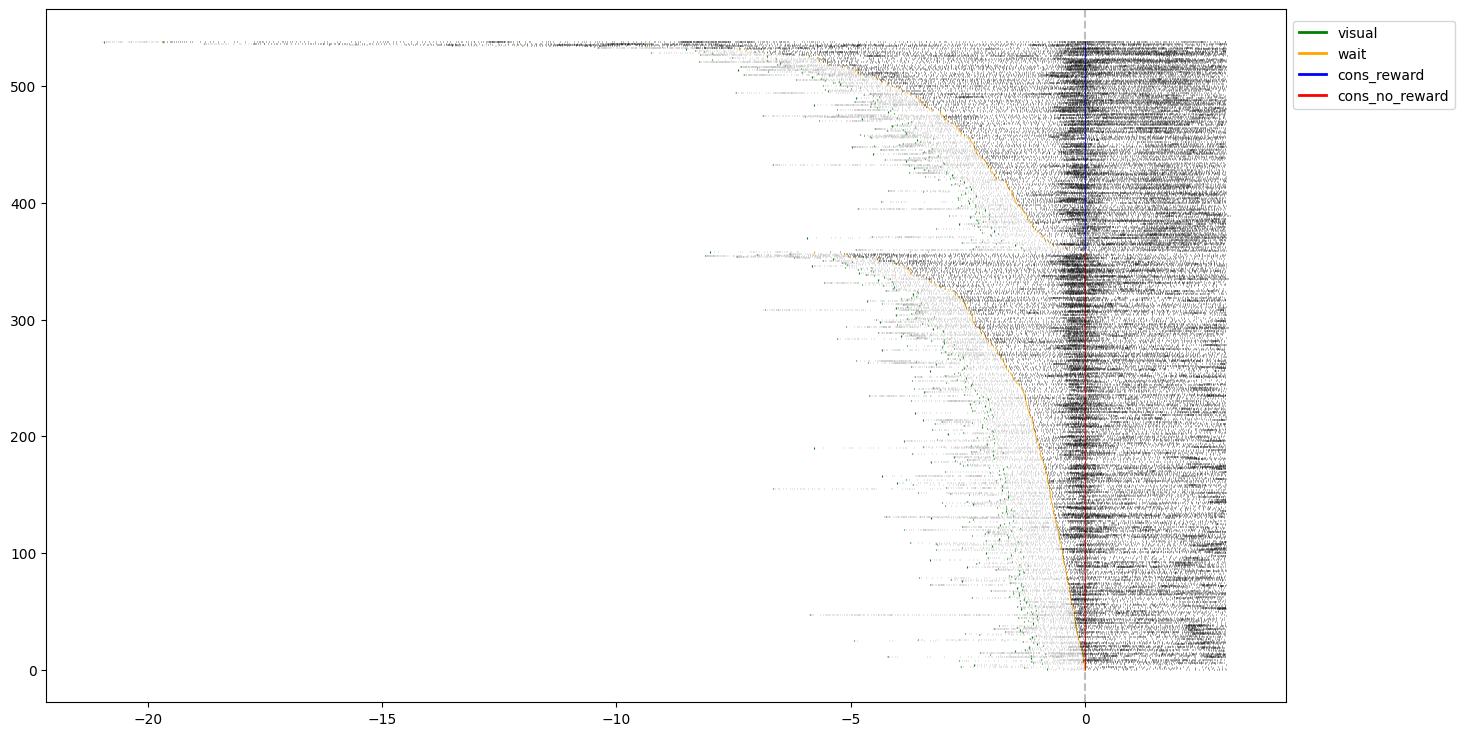

In [8]:
anchor = k.TO_DECISION
sorter = k.REWARD_WAIT_LENGTH
_, ax = plt.subplots(figsize=(16,9))
events_raster, spikes_raster, sorted_trial_id = prepare_data_for_raster(events, trials, spikes, sorter)
plot_raster(ax, sorted_trial_id, events_raster, spikes_raster, anchor, k.ANCHORED_PERIODS)

### histo plot

In [9]:
def prepare_data_for_histogram_by_outcome(trials, spikes, anchor, anchored_periods):
    # Calculate the aligned start and end time based on the anchor
    if anchor == k.TO_CUE_ON:
        # boundaries: trial start (0) -> cue off time
        trials['aligned_start_time'] = 0 - trials["cue_on_time"]
        trials['aligned_end_time'] = trials['cue_off_time'] - trials["cue_on_time"]
    
    elif anchor == k.TO_CUE_OFF:
        # boundaries: cue on time -> consumption time (or trial_length if consumption is missing)
        trials['aligned_start_time'] = trials['cue_on_time'] - trials["cue_off_time"]
        # Handle missing decision_time
        mask = trials['decision_time'].isna()
        trials.loc[~mask, 'aligned_end_time'] = trials['decision_time'] - trials["cue_off_time"]
        trials.loc[mask, 'aligned_end_time'] = trials['trial_length'] - trials["cue_off_time"]
    
    elif anchor == k.TO_DECISION:
        # boundaries: cue off time -> trial end
        trials['aligned_start_time'] = trials["cue_off_time"] - trials["decision_time"]
        trials['aligned_end_time'] = trials['trial_length'] - trials["decision_time"]
    
    # get spikes from ancored periods
    relevant_periods = anchored_periods[anchor]
    spikes_histo = spikes.loc[spikes.period.isin(relevant_periods)].copy()
    
    # get trials with spikes
    trials_with_spikes = spikes_histo['trial_id'].unique()
    trials_histo = trials[trials['trial_id'].isin(trials_with_spikes)].copy()

    return trials_histo, spikes_histo

In [10]:
def plot_firing_rates_by_outcome(ax, trials, spikes, anchor, time_step, sigma, trial_count_mask, show_legend=True):
    """Plots firing rates on given axes with legend on the right."""
    ax.axvline(0, color='tab:gray', linestyle='--', alpha=0.5, label=anchor)
    
    # Calculate rates for all trials
    bin_centers, mean_fr, sem_fr = calculate_firing_rates(
        trials, spikes, anchor, time_step, trial_count_mask, sigma
    )
    if len(bin_centers) > 0:
        ax.plot(bin_centers, mean_fr, 'k-', lw=1, alpha=0.8, label='All trials')
        ax.fill_between(bin_centers, mean_fr-sem_fr, mean_fr+sem_fr, color='gray', alpha=0.4)
        # trials_sorted = trials.sort_values('quantile')
    
    # Missed trials (missed=True)
    if anchor != k.TO_DECISION:
        trials_missed = trials.loc[trials.missed == True]
        spikes_missed = spikes.loc[spikes.trial_id.isin(trials_missed.trial_id)]
        bin_centers_m, mean_fr_m, sem_fr_m = calculate_firing_rates(
            trials_missed, spikes_missed, anchor, time_step, trial_count_mask, sigma
        )
        if len(bin_centers_m) > 0:
            ax.plot(bin_centers_m, mean_fr_m, color=missed_color, linestyle='-', lw=1, alpha=0.8, label='Missed')
            ax.fill_between(bin_centers_m, mean_fr_m-sem_fr_m, mean_fr_m+sem_fr_m, color=missed_color, alpha=0.3)
    
        # Non-missed unrewarded trials (missed=False and rewarded=False)
    trials_unrewarded = trials.loc[(trials.missed == False) & (trials.rewarded == False)]
    spikes_unrewarded = spikes.loc[spikes.trial_id.isin(trials_unrewarded.trial_id)]
    bin_centers_u, mean_fr_u, sem_fr_u = calculate_firing_rates(
        trials_unrewarded, spikes_unrewarded, anchor, time_step, trial_count_mask, sigma
    )
    if len(bin_centers_u) > 0:
        ax.plot(bin_centers_u, mean_fr_u, 'r-', lw=1, alpha=0.8, label='Unrewarded')
        ax.fill_between(bin_centers_u, mean_fr_u-sem_fr_u, mean_fr_u+sem_fr_u, color='r', alpha=0.3)
    
    # Rewarded trials (missed=False and rewarded=True)
    trials_rewarded = trials.loc[(trials.missed == False) & (trials.rewarded == True)]
    spikes_rewarded = spikes.loc[spikes.trial_id.isin(trials_rewarded.trial_id)]
    bin_centers_r, mean_fr_r, sem_fr_r = calculate_firing_rates(
        trials_rewarded, spikes_rewarded, anchor, time_step, trial_count_mask, sigma
    )
    if len(bin_centers_r) > 0:
        ax.plot(bin_centers_r, mean_fr_r, 'b-', lw=1, alpha=0.8, label='Rewarded')
        ax.fill_between(bin_centers_r, mean_fr_r-sem_fr_r, mean_fr_r+sem_fr_r, color='b', alpha=0.3)

    # Add the firing rate legend to the right of the plot
    if show_legend:
        ax.legend(bbox_to_anchor=(1, 1.05), loc='upper left')

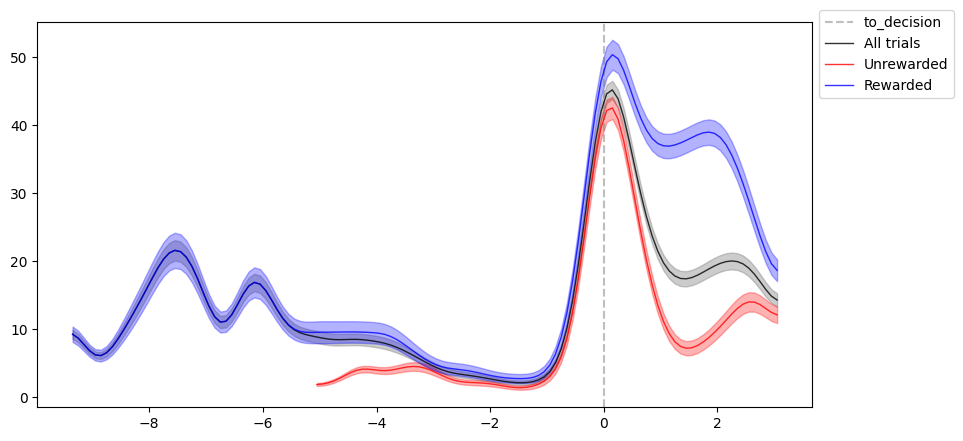

In [11]:
anchor = k.TO_DECISION

time_step = 0.1
sigma = 3
trial_count_mask = 5

_, ax = plt.subplots(figsize=(10, 5))
# events, trials, spikes, session_fr = get_data_for_debugging()
trials_histo, spikes_histo = prepare_data_for_histogram_by_outcome(trials, spikes, anchor, k.ANCHORED_PERIODS)
plot_firing_rates_by_outcome(ax, trials_histo, spikes_histo, anchor, time_step, sigma, trial_count_mask, show_legend=True)

### combined

In [52]:
def plot_raster_histo(unit_id, events, trials, spikes,
                      anchor, anchored_periods, sorter,
                      time_step, sigma, trial_count_mask, 
                      save_fig=False, regenerate=False, figure_folder=figure_dir):
    fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharex='col', gridspec_kw={'height_ratios': [3, 1]})
    plt.subplots_adjust(right=0.85)

    ax_raster = axes[0]
    ax_rate = axes[1]

    events_raster, spikes_raster, sorted_trial_id = prepare_data_for_raster(events, trials, spikes, sorter)
    plot_raster(ax_raster, sorted_trial_id, events_raster, spikes_raster, anchor, k.ANCHORED_PERIODS)

    trials_histo, spikes_histo = prepare_data_for_histogram_by_outcome(trials, spikes, anchor, anchored_periods)
    plot_firing_rates_by_outcome(ax_rate, trials_histo, spikes_histo, anchor, time_step, sigma, trial_count_mask, show_legend=True)

    ax_raster.set_ylabel("Trial #")
    ax_raster.set_title(f"{unit_id} aligned {anchor} sorted by outcome")
    ax_rate.set_ylabel("Firing Rate (Hz)")
    ax_rate.set_xlabel("Time (s)")

    # plt.suptitle(f"{unit_id} aligned {anchor} sorted by {sorter}")
    # plt.tight_layout() # causing 

    if save_fig:
        fig_path = f'{figure_folder}/{unit_id}.png'
        if regenerate or not os.path.exists(fig_path):
            fig.savefig(fig_path, bbox_inches='tight', dpi=300, format='png')
        fig.clf()
        plt.close(fig)
    else:
        plt.show()
        plt.close(fig)

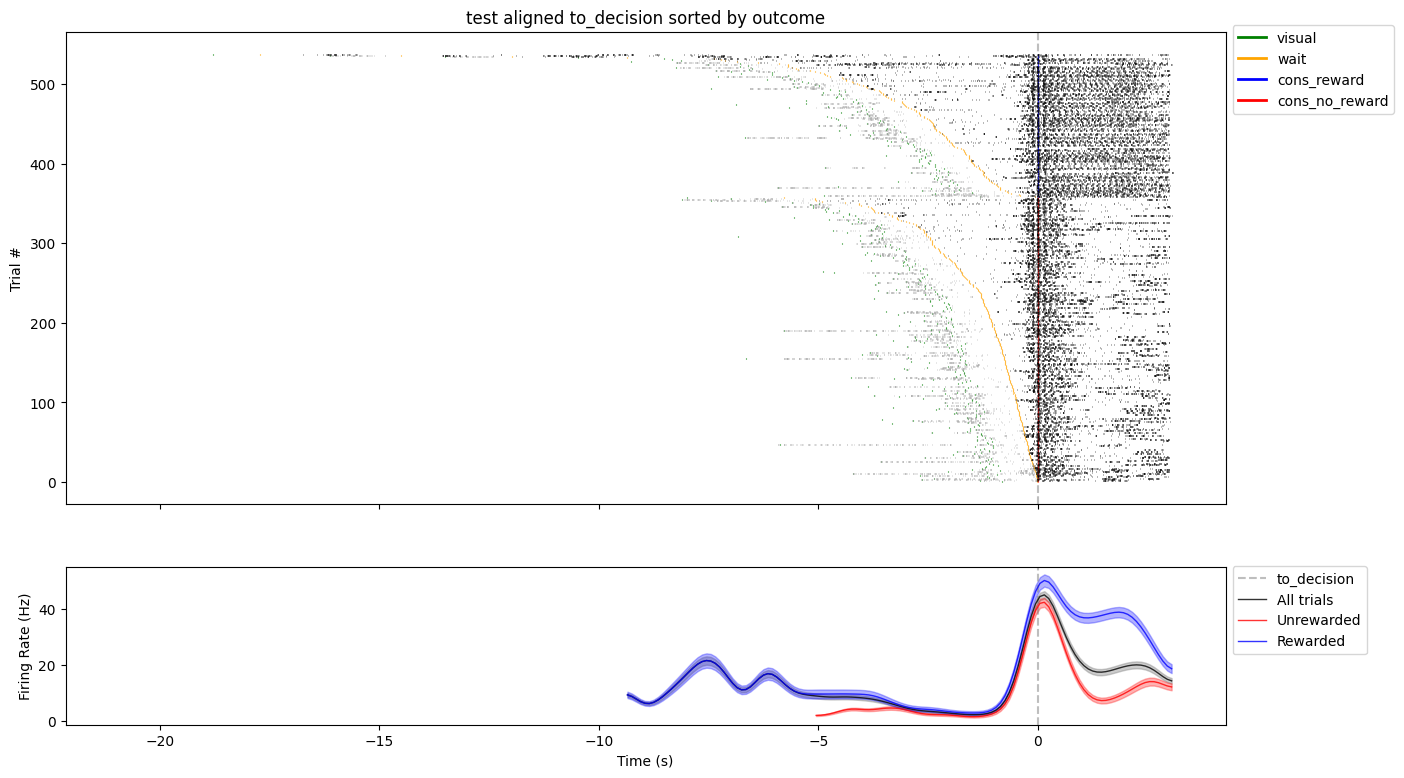

In [53]:
plot_raster_histo("test", events, trials, spikes,
                      anchor, k.ANCHORED_PERIODS, sorter,
                      time_step, sigma, trial_count_mask, 
                      save_fig=False, regenerate=False, figure_folder=figure_dir)

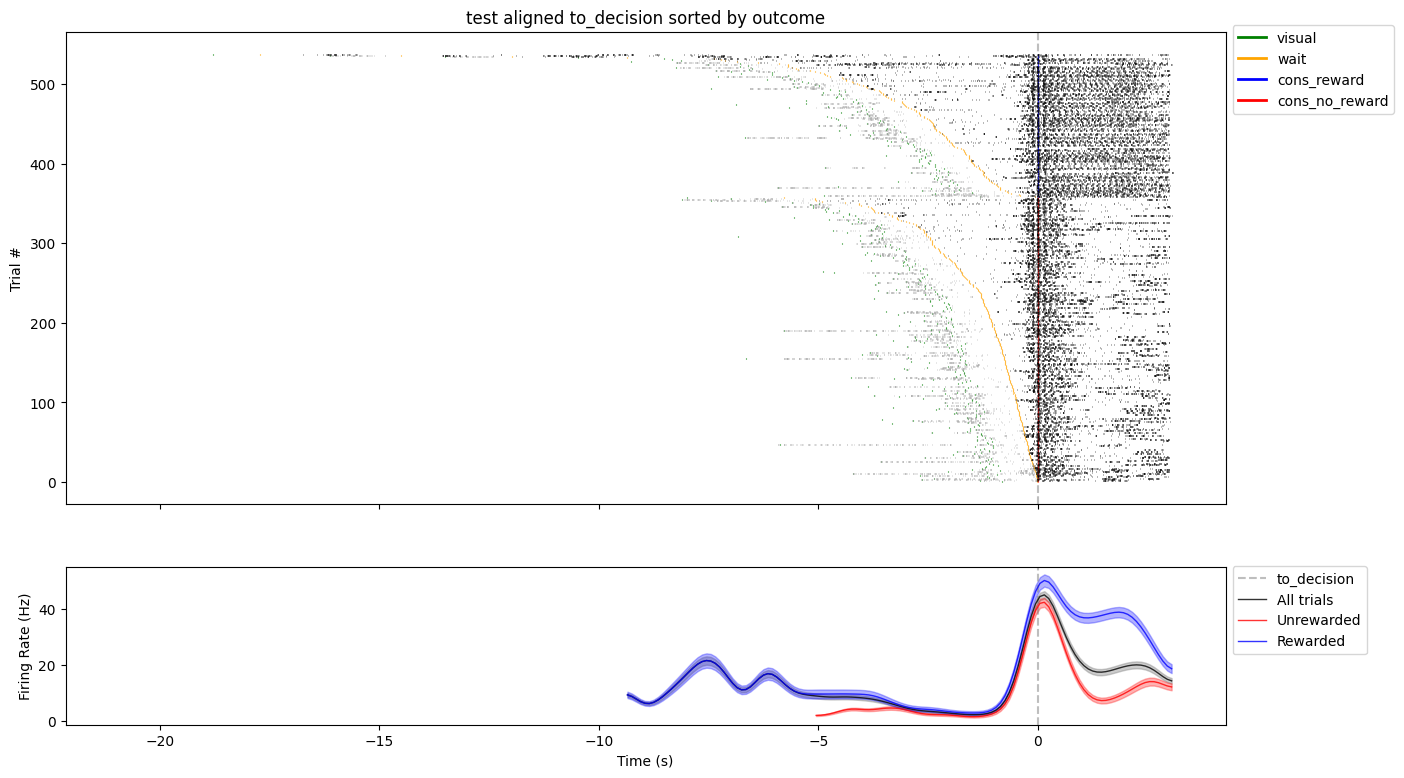

In [54]:
anchor = k.TO_DECISION
sorter = k.REWARD_WAIT_LENGTH
plot_raster_histo("test", events, trials, spikes,
                      anchor, k.ANCHORED_PERIODS, sorter,
                      time_step, sigma, trial_count_mask, 
                      save_fig=False, regenerate=False, figure_folder=figure_dir)

# Loop

loop through each anchor and sorter combo

In [ ]:
time_step = 0.1
sigma = 2
trial_count_mask = 5
save_fig = True
regenerate = False

In [ ]:
anchor = k.TO_DECISION
sorter = k.REWARD_WAIT_LENGTH

In [ ]:
# units_short= units_vetted.head(2)

In [ ]:
failed_units = []
plotted = 0
total_units = len(units_vetted)
units_grouped = units_vetted.groupby("session_id")

for session_id, session_units in units_grouped:
    print(f"plotting {session_id}")
    print(f"{round((plotted/total_units*100), 1)} % done")
    
    events, trials, units = utils.get_session_data(session_id, pickle_dir)
    
    region = session_units['region'].iloc[0]
    figure_folder = os.path.join(figure_dir, f"raster_histo_{anchor}_by_outcome", region)
    os.makedirs(figure_folder, exist_ok=True)
    
    for _, unit_info in session_units.iterrows():
        unit_id = unit_info['unit_id']
        spikes = units[unit_info['id']]
        figure_path = os.path.join(figure_folder, f"{unit_id}.png")
        
        if os.path.exists(figure_path) and not regenerate:
            plotted += 1
            continue
            
        try:
            plot_raster_histo(
                unit_id, events, trials, spikes,
                anchor, k.anchored_periods, sorter,
                time_step, sigma, trial_count_mask,
                save_fig, regenerate, figure_folder=figure_folder
            )
        except Exception as e:
            failed_units.append({
                'unit_id': unit_id,
                'error': str(e)
            })
        
        plotted += 1

# Print summary
if failed_units:
    print("\nFailed units:")
    for unit in failed_units:
        print(f"Session {unit['session_id']}, Unit {unit['unit_id']}: {unit['error']}")
    print(f"\nTotal failed: {len(failed_units)}/{len(units_vetted)}")
else:
    print("All units processed successfully!")